In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

import branca
import folium
import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None) 

from calitp import get_engine

engine = get_engine()
connection = engine.connect()

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


# Correlation and VIF in Analytical File

In [2]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [3]:
# start with trips per stop and ridership
analysis_tbl = gpd.read_parquet(f"{GCS_FILE_PATH}analytical_tbl.parquet")
analysis_tbl >> head (5)

,calitp_itp_id,stop_id,geometry,stop_name,n_trips_weekday,n_trips_sat,n_trips_sun,n_routes_weekday,n_routes_sat,n_routes_sun,sat_ons,sun_ons,weekday_ons,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_youth_pop,sum_seniors_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
0,293,423,POINT (25245.404 -397427.355),State & Alamar,60.0,56.0,55.0,3.0,2.0,2.0,567.0,566.0,4556.0,4.0,20153.0,9058.0,1370.0,180.0,3890.0,4776.0,4677.0,1124.0,1132.0,1703.0,19849.0,1676.0,115.0,448.0,8970055.0,12021.0,8.970055,2246.697484,1340.125562,0.067980,0.008932,0.193023,0.236987,0.232075,0.124089,0.124972,0.188011,0.084438,0.005706,0.049459
1,293,55,POINT (15628.312 -397010.130),Encina & Fairview,25.0,11.0,11.0,1.0,1.0,1.0,840.0,806.0,10303.0,2.0,7287.0,2572.0,644.0,133.0,1653.0,2109.0,1670.0,165.0,266.0,517.0,7287.0,336.0,34.0,61.0,6030586.0,2686.0,6.030586,1208.340284,445.396185,0.088377,0.018252,0.226842,0.289420,0.229175,0.064152,0.103421,0.201011,0.046110,0.004666,0.023717
2,293,239,POINT (23548.788 -398980.627),Veronica Springs & Torino,12.0,12.0,8.0,1.0,1.0,1.0,28.0,10.0,175.0,1.0,3455.0,1502.0,310.0,0.0,649.0,765.0,1064.0,141.0,186.0,262.0,3371.0,206.0,0.0,161.0,4129069.0,383.0,4.129069,836.750367,92.756987,0.089725,0.000000,0.187844,0.221418,0.307959,0.093875,0.123835,0.174434,0.061109,0.000000,0.107190
3,293,63,POINT (28266.459 -399563.850),Haley & Garden,25.0,21.0,14.0,1.0,1.0,1.0,148.0,85.0,978.0,2.0,10410.0,3823.0,1792.0,313.0,6028.0,3492.0,1260.0,920.0,611.0,741.0,10228.0,1877.0,189.0,499.0,4544564.0,23265.0,4.544564,2290.648784,5119.302974,0.172142,0.030067,0.579059,0.335447,0.121037,0.240649,0.159822,0.193827,0.183516,0.018156,0.130526
4,293,509,POINT (33779.852 -397621.940),None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
analysis_tbl = (analysis_tbl
                >> select(-_["sum_tracts":"sum_jobs"])
               )

In [5]:
# correlation matrix
corr = analysis_tbl.corr()

/tmp/ipykernel_2014/13804554.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 [Text(0.5, 0, 'calitp_itp_id'),
  Text(1.5, 0, 'n_trips_weekday'),
  Text(2.5, 0, 'n_trips_sat'),
  Text(3.5, 0, 'n_trips_sun'),
  Text(4.5, 0, 'n_routes_weekday'),
  Text(5.5, 0, 'n_routes_sat'),
  Text(6.5, 0, 'n_routes_sun'),
  Text(7.5, 0, 'sat_ons'),
  Text(8.5, 0, 'sun_ons'),
  Text(9.5, 0, 'weekday_ons'),
  Text(10.5, 0, 'land_area_sqkm'),
  Text(11.5, 0, 'pop_density'),
  Text(12.5, 0, 'job_density'),
  Text(13.5, 0, 'pct_not_us_citizen_pop'),
  Text(14.5, 0, 'pct_black_pop'),
  Text(15.5, 0, 'pct_hispanic_pop'),
  Text(16.5, 0, 'pct_youth_pop'),
  Text(17.5, 0, 'pct_seniors_pop'),
  Text(18.5, 0, 'pct_inc_extremelylow'),
  Text(19.5, 0, 'pct_inc_verylow'),
  Text(20.5, 0, 'pct_inc_low'),
  Text(21.5, 0, 'pct_poverty'),
  Text(22.5, 0, 'pct_pop_workers_no_car'),
  Text(23.5, 0, 'pct_hh_no_cars')])

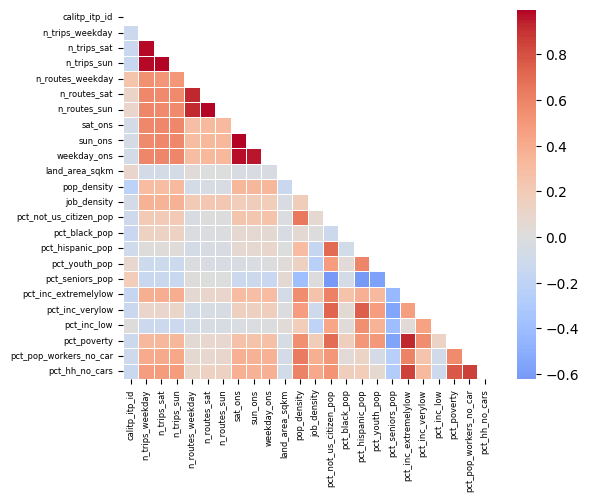

In [6]:
# Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype='bool')  
mask[np.triu_indices_from(mask)]=True

# heatmap
sns.heatmap(corr, 
            mask=mask, 
            cmap="coolwarm",
            square=True,
            linewidths=.5,
            center=0,
            xticklabels=True,
            yticklabels=True
           )

# changing the fontsize of yticks
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)

In [7]:
corr

,calitp_itp_id,n_trips_weekday,n_trips_sat,n_trips_sun,n_routes_weekday,n_routes_sat,n_routes_sun,sat_ons,sun_ons,weekday_ons,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
calitp_itp_id,1.000000,-0.125923,-0.135630,-0.153185,0.249646,0.116183,0.100330,-0.060168,-0.057338,-0.067490,0.103122,-0.220709,-0.064011,-0.108816,-0.136101,-0.094442,0.082672,0.180733,-0.156748,-0.133102,0.014457,-0.116756,-0.109125,-0.129698
n_trips_weekday,-0.125923,1.000000,0.983639,0.981628,0.539017,0.585081,0.587056,0.574626,0.572069,0.591070,-0.073842,0.301871,0.365813,0.198793,0.147410,0.013057,-0.111855,-0.130560,0.386721,0.103615,-0.123796,0.323503,0.406305,0.478248
n_trips_sat,-0.135630,0.983639,1.000000,0.996076,0.509754,0.568034,0.570117,0.577154,0.573980,0.585897,-0.073707,0.313112,0.358223,0.207027,0.137707,0.018273,-0.111540,-0.133050,0.391731,0.103001,-0.123356,0.332330,0.418849,0.487975
n_trips_sun,-0.153185,0.981628,0.996076,1.000000,0.507522,0.567735,0.571441,0.576279,0.574249,0.585867,-0.074205,0.316845,0.364250,0.208537,0.138744,0.019392,-0.114292,-0.134425,0.393284,0.107121,-0.123157,0.333005,0.421781,0.490376
n_routes_weekday,0.249646,0.539017,0.509754,0.507522,1.000000,0.922920,0.919208,0.291313,0.300513,0.299192,0.023714,-0.066822,0.208212,-0.031394,-0.019468,-0.069042,-0.018913,0.013900,0.067795,-0.073858,-0.071145,0.053699,0.062243,0.107144
n_routes_sat,0.116183,0.585081,0.568034,0.567735,0.922920,1.000000,0.996295,0.318192,0.327690,0.326671,0.000496,-0.041858,0.229239,0.004096,-0.015624,-0.035337,-0.039086,-0.005663,0.096317,-0.049607,-0.046649,0.081838,0.084780,0.135124
n_routes_sun,0.100330,0.587056,0.570117,0.571441,0.919208,0.996295,1.000000,0.319328,0.328908,0.327945,0.000360,-0.039430,0.229781,0.004661,-0.014169,-0.035526,-0.039823,-0.009018,0.097811,-0.046501,-0.046646,0.083349,0.087210,0.137429
sat_ons,-0.060168,0.574626,0.577154,0.576279,0.291313,0.318192,0.319328,1.000000,0.985334,0.973116,-0.034878,0.344117,0.186183,0.248320,0.061561,0.069966,-0.028243,-0.126058,0.301395,0.152018,-0.022974,0.268583,0.380086,0.382807
sun_ons,-0.057338,0.572069,0.573980,0.574249,0.300513,0.327690,0.328908,0.985334,1.000000,0.961661,-0.033745,0.338759,0.178655,0.241407,0.062356,0.068842,-0.024500,-0.121910,0.289779,0.150686,-0.016095,0.257085,0.364145,0.366979
weekday_ons,-0.067490,0.591070,0.585897,0.585867,0.299192,0.326671,0.327945,0.973116,0.961661,1.000000,-0.036471,0.339881,0.185941,0.258964,0.060291,0.090504,-0.011794,-0.138724,0.302140,0.171711,-0.010442,0.273040,0.364107,0.372474


## scatterplots of highly correlated variables

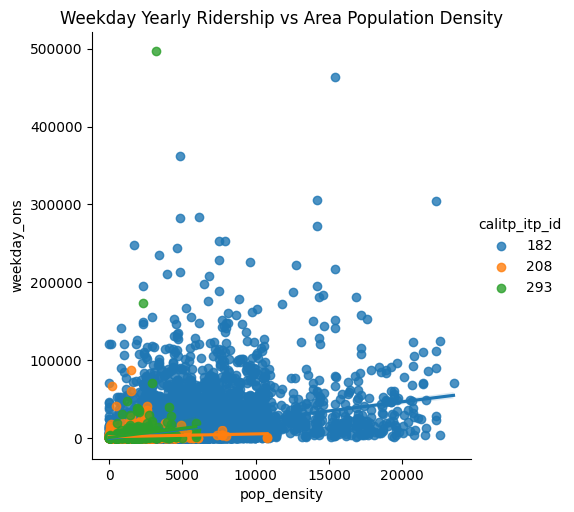

In [8]:
sns.lmplot(x="pop_density",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Yearly Ridership vs Area Population Density")

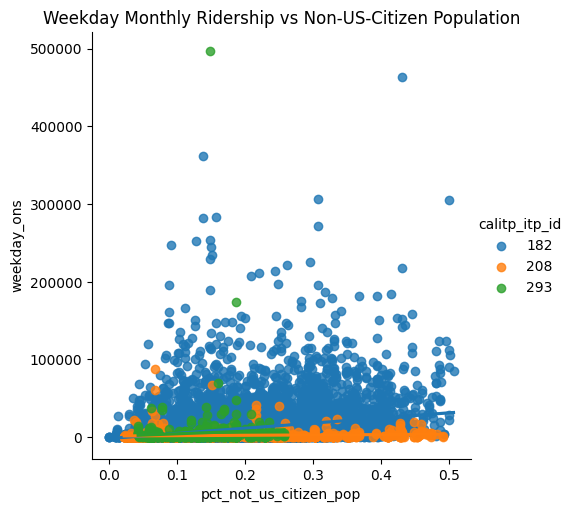

In [9]:
sns.lmplot(x="pct_not_us_citizen_pop",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Non-US-Citizen Population")

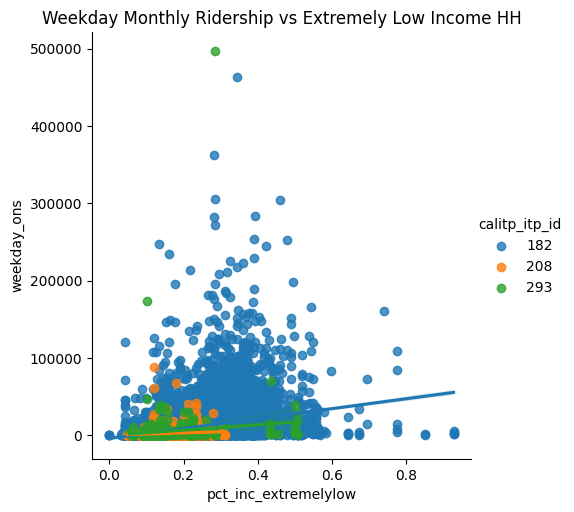

In [10]:
sns.lmplot(x="pct_inc_extremelylow",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Extremely Low Income HH")

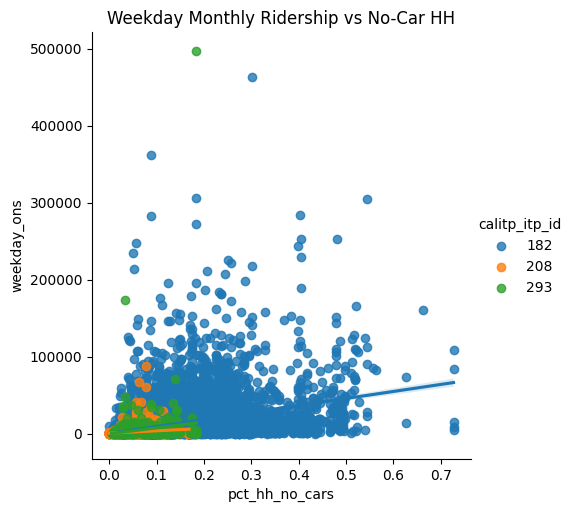

In [11]:
sns.lmplot(x="pct_hh_no_cars",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs No-Car HH")

## VIF

In [12]:
# VIF function wrapper using Pandas - from Blake
def calc_vif(df:pd.DataFrame):
    '''
    Determine the variation inflaction factor for all columns in a dataframe.
    
    VIF calculation assumes a constant, so one is added as part of a wrapper function.
    https://github.com/statsmodels/statsmodels/issues/2376
    '''
    df_c = df.assign(const=1)
    vif = pd.Series([variance_inflation_factor(df_c.values, i) 
                                    for i in range(df_c.shape[1])],
                       index=df_c.columns)
    vif.drop(index=['const'], inplace=True)
    return(vif)

In [13]:
# make a regular df, drop nans
analysis_tbl_df = pd.DataFrame(analysis_tbl)
analysis_tbl_df = (analysis_tbl_df.dropna() >> select(-_["stop_name", "stop_id","geometry"]))

analysis_tbl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12988 entries, 0 to 13729
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calitp_itp_id           12988 non-null  int64  
 1   n_trips_weekday         12988 non-null  float64
 2   n_trips_sat             12988 non-null  float64
 3   n_trips_sun             12988 non-null  float64
 4   n_routes_weekday        12988 non-null  float64
 5   n_routes_sat            12988 non-null  float64
 6   n_routes_sun            12988 non-null  float64
 7   sat_ons                 12988 non-null  float64
 8   sun_ons                 12988 non-null  float64
 9   weekday_ons             12988 non-null  float64
 10  land_area_sqkm          12988 non-null  float64
 11  pop_density             12988 non-null  float64
 12  job_density             12988 non-null  float64
 13  pct_not_us_citizen_pop  12988 non-null  float64
 14  pct_black_pop           12988 non-null

In [14]:
calc_vif(analysis_tbl_df)

calitp_itp_id               1.497976
n_trips_weekday            35.965912
n_trips_sat               159.127209
n_trips_sun               143.550749
n_routes_weekday            8.446955
n_routes_sat              149.180133
n_routes_sun              146.129487
sat_ons                    51.315883
sun_ons                    35.438101
weekday_ons                20.544775
land_area_sqkm              1.045884
pop_density                 2.603291
job_density                 1.477824
pct_not_us_citizen_pop      5.465196
pct_black_pop               1.469640
pct_hispanic_pop            3.709427
pct_youth_pop               2.819491
pct_seniors_pop             2.444137
pct_inc_extremelylow       11.990896
pct_inc_verylow             3.124042
pct_inc_low                 1.880337
pct_poverty                11.695884
pct_pop_workers_no_car      6.113923
pct_hh_no_cars             12.971668
dtype: float64

## Summary Stats by operator area

Text(0, 0.5, 'Number of Stops')

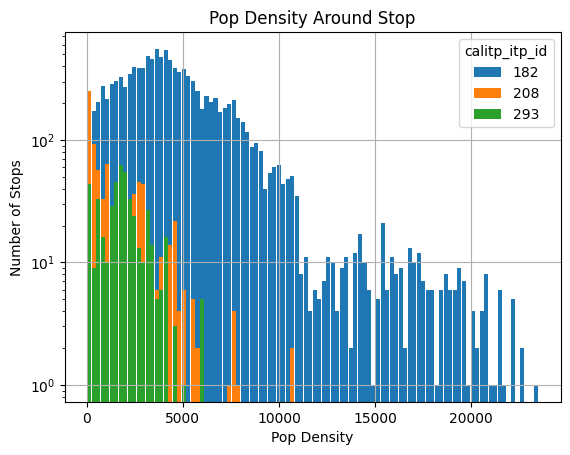

In [15]:
analysis_tbl_df.pivot(columns='calitp_itp_id', values='pop_density').plot.hist(grid=True, bins=100, rwidth=0.9, log=True,
                                          title='Pop Density Around Stop')
plt.xlabel('Pop Density')
plt.ylabel('Number of Stops')

In [16]:
analysis_tbl_df >> group_by(_.calitp_itp_id) >> summarize(pop_density_mean=_.pop_density.mean())

,calitp_itp_id,pop_density_mean
0,182,4596.657172
1,208,1438.560768
2,293,1868.587288
